In [6]:
import numpy as np              # Para operações numéricas, np.nan, np.where, etc.
import pandas as pd             # Para manipulação de DataFrame
from scipy.signal import find_peaks   # Para identificar picos e fundos
from scipy.interpolate import interp1d  # Para fazer a interpolação linear
import matplotlib.pyplot as plt

1 - This notebook will select the highest high within an X distance and mark it as a peak, and vice versa for troughs.

2 - After peaks and troughs are marked, a line will be created connecting the points.

3 - Once the line is created, the percentage change of its value will be calculated, and the target will be labeled as "up" if the percentage change of both lines (peaks and troughs) is greater than the threshold_pct, and vice versa for a "down" trend.

In [16]:
df = pd.read_csv('win.csv')
df = df[:500]

Creating peaks and troughs

In [17]:
peak_value = 10  # Selecting the minimum distance between peaks and troughs

In [18]:
# CREATING PEAKS
peaks = None
troughs = None
x_peaks = None
y_peaks = None
x_troughs = None
y_troughs = None

df['peaks'] = np.nan
df['troughs'] = np.nan

# Identify peaks and troughs
peaks, _ = find_peaks(df['close'], distance=peak_value)
troughs, _ = find_peaks(-df['close'], distance=peak_value)

# Fill real values at the points
df.loc[peaks, 'peaks'] = df['close'].iloc[peaks]
df.loc[troughs, 'troughs'] = df['close'].iloc[troughs]


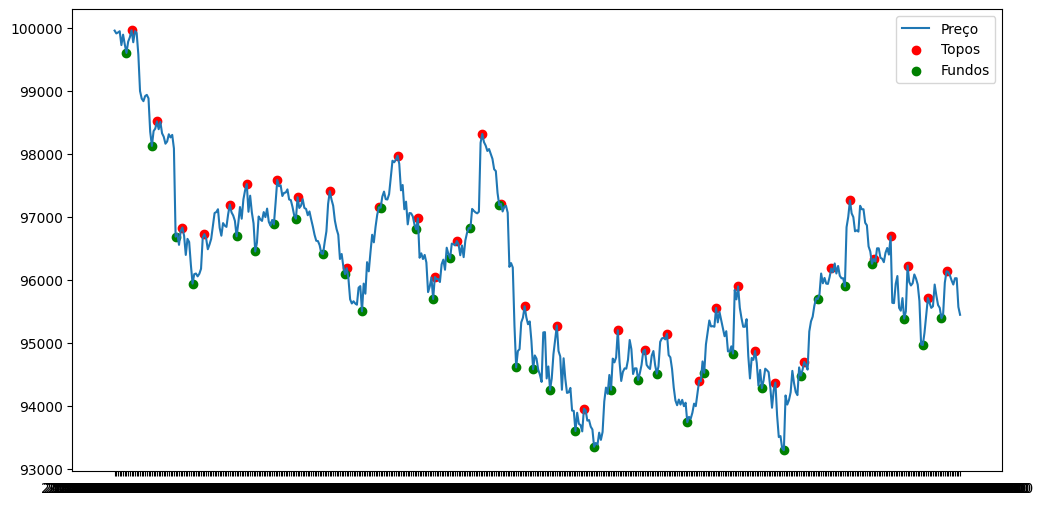

In [19]:
# 5. Visualização
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['close'], label='Preço')
plt.scatter(df['time'].iloc[peaks], df['close'].iloc[peaks], color='red', label='Topos')
plt.scatter(df['time'].iloc[troughs], df['close'].iloc[troughs], color='green', label='Fundos')
plt.legend()
plt.show()


Connecting the points

In [20]:
# Linear interpolation between peaks
if len(peaks) > 1:
    f_peaks = interp1d(peaks, df['close'].iloc[peaks], kind='linear', fill_value="extrapolate")
    df['peaks'] = f_peaks(np.arange(len(df)))
else:
    # Only one peak, fill with it
    df['peaks'] = df['close'].iloc[peaks[0]]

# Linear interpolation between troughs
if len(troughs) > 1:
    f_troughs = interp1d(troughs, df['close'].iloc[troughs], kind='linear', fill_value="extrapolate")
    df['troughs'] = f_troughs(np.arange(len(df)))
else:
    # Only one trough, fill with it
    df['troughs'] = df['close'].iloc[troughs[0]]


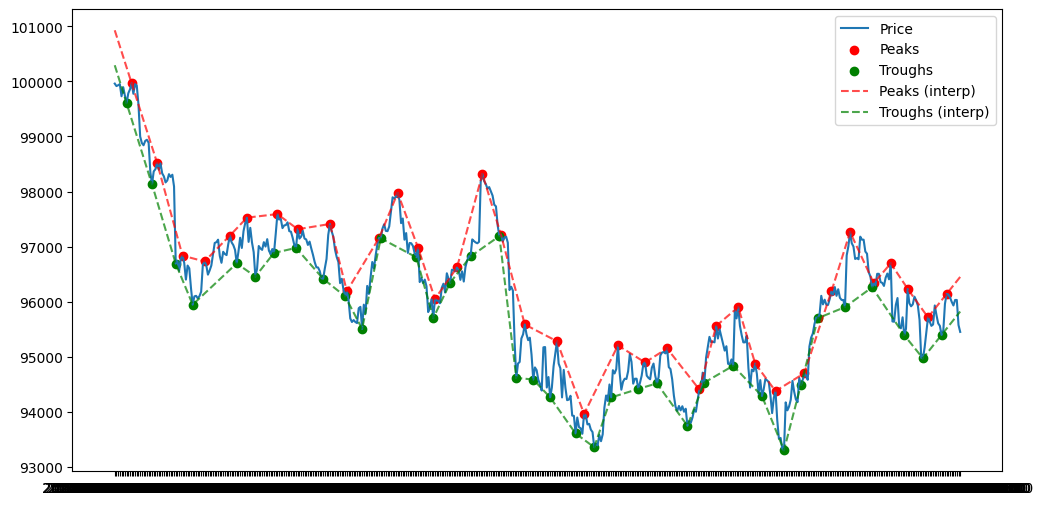

In [25]:
# 5. Visualization
plt.figure(figsize=(12, 6))

# Plot price
plt.plot(df['time'], df['close'], label='Price')

# Plot peaks and troughs points
plt.scatter(df['time'].iloc[peaks], df['close'].iloc[peaks], color='red', label='Peaks')
plt.scatter(df['time'].iloc[troughs], df['close'].iloc[troughs], color='green', label='Troughs')

# Plot interpolated lines
plt.plot(df['time'], df['peaks'], color='red', linestyle='--', alpha=0.7, label='Peaks (interp)')
plt.plot(df['time'], df['troughs'], color='green', linestyle='--', alpha=0.7, label='Troughs (interp)')

plt.legend()
plt.show()


Creating the target based on inclination

In [26]:
threshold_pct = 1  # Selecting the minimum slope required to set the lines connecting the peaks and troughs as trend up/trend down or neutral

In [27]:
# INCLINATION INDICATOR
df['pct_peaks'] = df.peaks.pct_change() * 10000
df['pct_troughs'] = df.troughs.pct_change() * 10000

# TARGET
df['target'] = np.where(
    (df['pct_peaks'] >= threshold_pct) & (df['pct_troughs'] >= threshold_pct),  # uptrend condition
    1,
    np.where(
        (df['pct_peaks'] <= -threshold_pct) & (df['pct_troughs'] <= -threshold_pct),  # downtrend condition
        -1,
        0  # neutral
    )
)


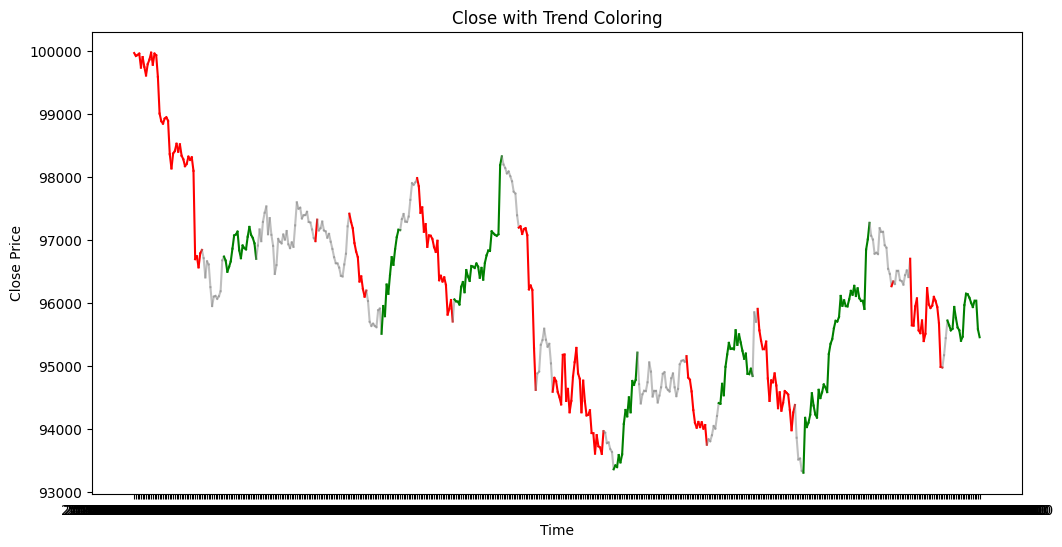

In [30]:
plt.figure(figsize=(12,6))

# Loop through the dataframe and plot segments depending on target
for i in range(1, len(df)):
    if df['target'].iloc[i] == 1:  # uptrend
        plt.plot(df['time'].iloc[i-1:i+1], df['close'].iloc[i-1:i+1], color='green')
    elif df['target'].iloc[i] == -1:  # downtrend
        plt.plot(df['time'].iloc[i-1:i+1], df['close'].iloc[i-1:i+1], color='red')
    else:  # neutral
        plt.plot(df['time'].iloc[i-1:i+1], df['close'].iloc[i-1:i+1], color='gray', alpha=0.5)

plt.title("Close with Trend Coloring")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()
